Importação de todas as bibliotecas necessárias

In [1]:
import os
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import os
import urllib.request
import zipfile
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\letsm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\letsm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\letsm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Acquisition

In [26]:
def fetch_data(download_url, output_dir="data/raw"):
    """
    Função que baixa os dados de reclamações a partir de uma URL fornecida usando urllib e descompacta o arquivo ZIP.
    
    Parâmetros:
    download_url: string contendo a url para download
    output_dir: diretório onde será salvo os dados descompactados.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Baixando o arquivo .zip usando urllib
        file_name = download_url.split("/")[-1]
        output_path = os.path.join(output_dir, file_name)
        
        # Fazendo o download do arquivo
        urllib.request.urlretrieve(download_url, output_path)
        print(f"Arquivo ZIP salvo em: {output_path}")
        
        # Descompactando o arquivo ZIP
        with zipfile.ZipFile(output_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
            print(f"Arquivos descompactados em: {output_dir}")
        
        # Removendo o arquivo ZIP após descompactar
        os.remove(output_path)
        print(f"Arquivo ZIP {file_name} removido.")
    
    except Exception as e:
        print(f"Erro ao baixar ou descompactar os dados: {e}")

fetch_data("https://static.nhtsa.gov/odi/ffdd/cmpl/COMPLAINTS_RECEIVED_2015-2019.zip")

Arquivo ZIP salvo em: data/raw\COMPLAINTS_RECEIVED_2015-2019.zip
Arquivos descompactados em: data/raw
Arquivo ZIP COMPLAINTS_RECEIVED_2015-2019.zip removido.


Preprocessing and Feature Engineering

In [45]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Função para limpar e pré-processar o texto.
    
    Parâmetros:
    text: string contendo o texto que o usuário deseja processar.
    """
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(text.lower())  # Tokenizar e converter para minúsculo
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]  # Remover stopwords e lematizar
    return ' '.join(tokens)


In [64]:
def process_data(input_file):
    """
    Aplica o pré-processamento e limpeza nos dados para o treinamento ser feito de maneira eficiente e eficaz,
    salva o arquivo processado com as modificações.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo que será feito o pré-processamento e limpeza.
    
    """
    
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return
    
    try:
        df = pd.read_csv(input_file)
        print("Arquivo carregado com sucesso! Primeiras linhas:")
        print(df.head())
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        return
    
    df.columns = [
        "CMPLID", "ODINO", "MFR_NAME", "MAKETXT", "MODELTXT", "YEARTXT", "CRASH", "FAILDATE",
        "FIRE", "INJURED", "DEATHS", "COMPDESC", "CITY", "STATE", "VIN", "DATEA", "LDATE", "MILES",
        "OCCURENCES", "CDESCR", "CMPL_TYPE", "POLICE_RPT_YN", "PURCH_DT", "ORIG_OWNER_YN", "ANTI_BRAKES_YN",
        "CRUISE_CONT_YN", "NUM_CYLS", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "VEH_SPEED",
        "DOT", "TIRE_SIZE", "LOC_OF_TIRE", "TIRE_FAIL_TYPE", "ORIG_EQUIP_YN", "MANUF_DT", "SEAT_TYPE",
        "RESTRAINT_TYPE", "DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", 
        "PROD_TYPE", "REPAIRED_YN", "MEDICAL_ATTN", "VEHICLES_TOWED_YN"
    ]
    
    # Limpeza das colunas de texto
    df["CDESCR"] = df["CDESCR"].astype(str).apply(clean_text)
    df["COMPDESC"] = df["COMPDESC"].astype(str).apply(clean_text)
    
    # Excluindo as colunas não necessárias
    df = df.drop(columns=[ 
        "VIN", "ODINO", "MFR_NAME", "MAKETXT", "CITY", "STATE", "DEALER_NAME", 
        "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", "DOT", "TIRE_SIZE", 
        "LOC_OF_TIRE", "SEAT_TYPE", "RESTRAINT_TYPE", "CMPLID", "FAILDATE",
        "DATEA", "LDATE", "MILES", "PURCH_DT", "NUM_CYLS", "VEH_SPEED", "ORIG_EQUIP_YN",
        "MANUF_DT", "REPAIRED_YN"
    ])
    
    # Transformação de dados binários
    binary_columns = ["CRASH", "FIRE", "POLICE_RPT_YN", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", 
                      "CRUISE_CONT_YN", "MEDICAL_ATTN", "VEHICLES_TOWED_YN"]
    for col in binary_columns:
        df[col] = df[col].map({'Y': 1, 'N': 0})
    
    categorical_columns = ["CMPL_TYPE", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "TIRE_FAIL_TYPE", "PROD_TYPE"]
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    # Vetorização das colunas de texto (CDESCR, COMPDESC)
    text_columns = ['CDESCR', 'COMPDESC']
    vectorizer = TfidfVectorizer(max_features=50)
    
    # Concatenando as duas colunas de texto para aplicação do TF-IDF
    combined_text = df[text_columns].apply(lambda x: ' '.join(x), axis=1)
    
    # Aplicando o TF-IDF
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    
    # Convertendo a matriz TF-IDF em um DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Removendo as colunas de texto antes de processar os dados restantes
    df = df.drop(columns=text_columns)

    # Preprocessamento das colunas numéricas e categóricas
    preprocessor = ColumnTransformer([ 
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])
    
    # Aplicando a transformação apenas nas colunas numéricas e categóricas
    df_transformed = preprocessor.fit_transform(df)
    
    # Criando um DataFrame com as colunas processadas
    df_transformed = pd.DataFrame(df_transformed, columns= 
                                  numeric_columns + 
                                  list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)))
    
    # Concatenando o TF-IDF com o restante dos dados transformados
    df_final = pd.concat([df_transformed, tfidf_df], axis=1)

    # Salvando o DataFrame processado
    output_file = input_file.replace("raw", "processed")
    try:
        df_final.to_csv(output_file, index=False)
        print(f"Arquivo processado salvo em: {output_file}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo: {e}")
        return

    if os.path.exists(output_file):
        print(f"Arquivo CSV processado com sucesso: {output_file}")
    else:
        print(f"Erro: O arquivo CSV não foi gerado.")


In [65]:
def create_processed_file(input_file="data/raw/COMPLAINTS_RECEIVED_2015-2019.txt", output_dir="data/processed"):
    """
    Cria um arquivo processado .csv a partir do arquivo de dados bruto baixado.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados bruto que vai ser processado e transformado em .csv.
    output_dir: string contendo o path para o diretório onde o arquivo processado vai ser criado e salvo.
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return
    
    try:
        df = pd.read_csv(input_file, sep="\t", header=None)
        print("Arquivo carregado com sucesso! Primeiras linhas:")
        print(df.head())
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        return
    
    consolidated_file = os.path.join(output_dir, "complaints.csv")
    try:
        df.to_csv(consolidated_file, index=False)
        print(f"Arquivo carregado salvo em: {consolidated_file}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo: {e}")
        return
    
    if os.path.exists(consolidated_file):
        print(f"Arquivo CSV gerado com sucesso: {consolidated_file}")
        process_data(consolidated_file)
    else:
        print(f"Erro: O arquivo CSV não foi gerado.")


In [67]:
create_processed_file()

C:\Users\letsm\AppData\Local\Temp\ipykernel_3632\4240447826.py:11: DtypeWarning: Columns (15,16,18,28,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, sep="\t", header=None)


Arquivo carregado com sucesso! Primeiras linhas:
        0       1                    2    3             4       5  6   \
0  1143612  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
1  1143613  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
2  1143614  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
3  1143615  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
4  1143616  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   

         7  8   9   ...   39                          40   41   42   43   44  \
0  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
1  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
2  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
3  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
4  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   

  45   46 47 48  
0  V  NaN  N 

C:\Users\letsm\AppData\Local\Temp\ipykernel_3632\2338492838.py:9: DtypeWarning: Columns (15,16,18,28,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Arquivo carregado com sucesso! Primeiras linhas:
         0       1                    2    3             4       5  6  \
0  1143612  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
1  1143613  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
2  1143614  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
3  1143615  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
4  1143616  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   

          7  8  9  ...   39                          40   41   42   43   44  \
0  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
1  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
2  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
3  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
4  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   

  45   46 47 48  
0  V  NaN  N  N  
1

Exploratory Analysis

In [11]:
def plot_valid_counts(input_file):
    """
    Gera um gráfico de barras mostrando a quantidade de valores válidos (não nulos) em cada coluna.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para plotar o gráfico.
    """
    # Verificar se o arquivo existe
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    # Carregar o dataset
    try:
        df = pd.read_csv(input_file)
        print("Arquivo carregado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Contar valores válidos (não nulos) em cada coluna
    valid_counts = df.notnull().sum()

    # Criar o gráfico
    plt.figure(figsize=(12, 6))
    valid_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Quantidade de Valores Válidos por Coluna", fontsize=16)
    plt.xlabel("Colunas", fontsize=12)
    plt.ylabel("Quantidade de Valores Válidos", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

def exploratory_analysis(input_file):
    """
    Realiza uma análise exploratória básica dos dados.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para fazer a análise exploratória.
    """
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    try:
        df = pd.read_csv(input_file, low_memory=False)
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Exibir as primeiras linhas
    print("\nPrimeiras linhas do dataset:")
    print(df.head())

    # Informações gerais
    print("\nInformações gerais do dataset:")
    print(df.info())

    # Estatísticas descritivas
    print("\nEstatísticas descritivas:")
    print(df.describe(include=['number']))

    # Verificar valores ausentes
    print("\nValores ausentes por coluna:")
    print(df.isnull().sum())

    # Análise de distribuições
    print("\nDistribuições das variáveis categóricas:")
    for col in df.select_dtypes(include=['object', 'bool']):
        print(f"\n{col} - Distribuição de valores:")
        print(df[col].value_counts())



def show_unique_values(input_file):
    """
    Mostra os valores únicos de cada variável.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para verificar os valores únicos de cada
    variável.
    """
    # Verificar se o arquivo existe
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    try:
        df = pd.read_csv(input_file)
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Selecionar apenas as colunas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Mostrar os valores únicos de cada variável numérica
    for col in numeric_columns:
        print(f"\nValores únicos em {col}:")
        unique_values = df[col].value_counts().sort_index()  # Contagem dos valores únicos
        print(unique_values)

    print("\nValores únicos de todas as variáveis numéricas foram exibidos.")




Arquivo carregado com sucesso!


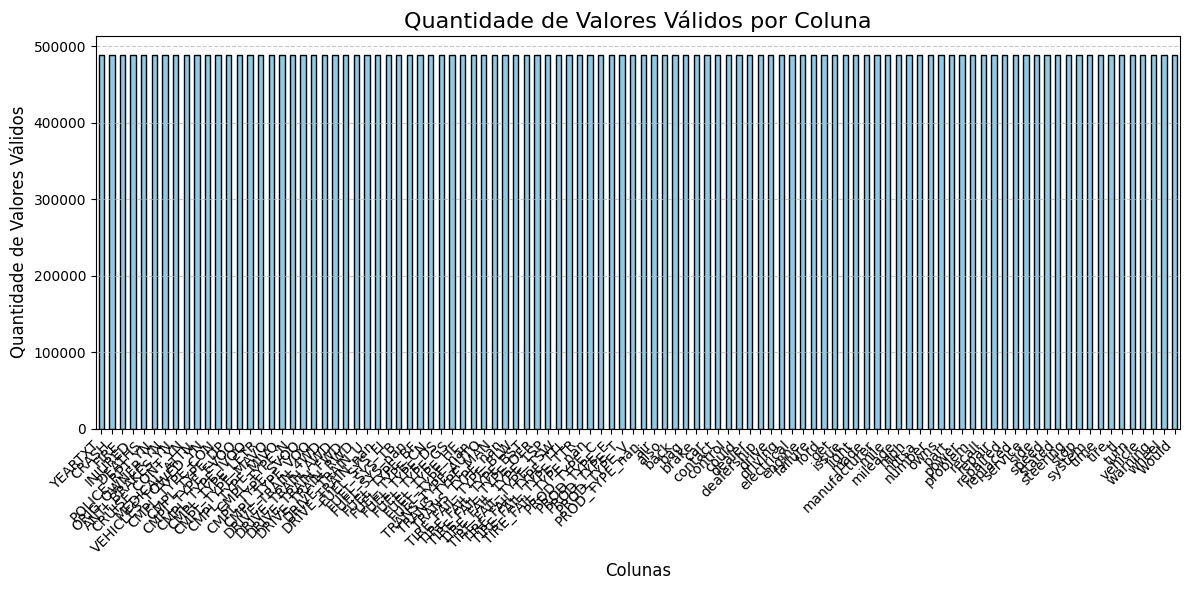


Primeiras linhas do dataset:
    YEARTXT     CRASH      FIRE   INJURED    DEATHS  POLICE_RPT_YN  \
0 -0.113268 -0.246887 -0.154309 -0.140078 -0.011693      -0.189775   
1 -0.113268 -0.246887 -0.154309 -0.140078 -0.011693      -0.189775   
2 -0.113268 -0.246887 -0.154309 -0.140078 -0.011693      -0.189775   
3 -0.113268 -0.246887 -0.154309 -0.140078 -0.011693      -0.189775   
4 -0.113268 -0.246887 -0.154309 -0.140078 -0.011693      -0.189775   

   ORIG_OWNER_YN  ANTI_BRAKES_YN  CRUISE_CONT_YN  MEDICAL_ATTN  ...  stop  \
0        7.93199        7.175029        7.093571     -0.164461  ...   0.0   
1        7.93199        7.175029        7.093571     -0.164461  ...   0.0   
2        7.93199        7.175029        7.093571     -0.164461  ...   0.0   
3        7.93199        7.175029        7.093571     -0.164461  ...   0.0   
4        7.93199        7.175029        7.093571     -0.164461  ...   0.0   

     system  time  tire   tl  turn  vehicle  warning  wheel  would  
0  0.679078   0.0

In [12]:
plot_valid_counts("data/processed/complaints.csv")
exploratory_analysis("data/processed/complaints.csv")
show_unique_values("data/processed/complaints.csv")


Imputing missing values

In [72]:
# Carregando o DataFrame
df = pd.read_csv("data/processed/complaints.csv")

def impute_missing_values(df):
    """
    Função que realiza imputação de valores ausentes nas colunas numéricas
    e categóricas, e salva as alterações no DataFrame.
    
    Parâmetros:
    df: DataFrame com dados a serem imputados.
    
    Retorna:
    df: DataFrame com valores ausentes imputados.
    """
    
    # Identificando colunas numéricas e categóricas
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Verifique se há colunas categóricas antes de tentar imputação
    if len(categorical_cols) > 0:
        print(f"Colunas categóricas encontradas: {categorical_cols}")
    else:
        print("Nenhuma coluna categórica encontrada.")

    # Se houver dados válidos nas colunas categóricas, prosseguimos com a imputação
    for col in categorical_cols:
        # Verifica se há valores nulos e imprime o número de valores ausentes
        print(f"Valores ausentes na coluna {col}: {df[col].isna().sum()}")

        # Garantir que as colunas categóricas estão no tipo 'category'
        df[col] = df[col].astype('category')

    # Imputação para colunas numéricas
    numerical_imputer = SimpleImputer(strategy='mean')

    # Imputação para colunas categóricas
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # Preenchendo os valores ausentes nas colunas numéricas
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    # Verifique novamente se há dados válidos nas colunas categóricas
    if len(categorical_cols) > 0:
        # Preenchendo os valores ausentes nas colunas categóricas
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    return df

df_imputado = impute_missing_values(df)
df_imputado.to_csv("data/processed/complaints.csv")

Nenhuma coluna categórica encontrada.


Arquivo carregado com sucesso!


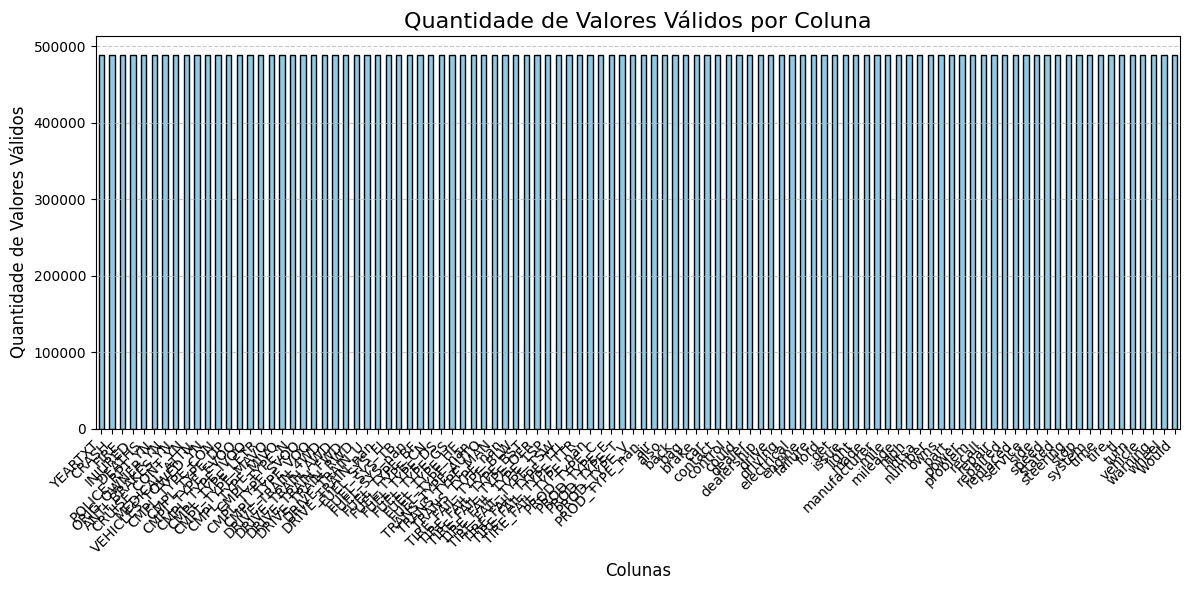

In [5]:
plot_valid_counts("data/processed/complaints.csv")

In [ ]:
DF = pd.read_csv("data/processed/complaints.csv")

def prepare_models_and_split(df):
    """
    Função para preparar os dados e os modelos, realizar a divisão de treino e teste.
    
    Parâmetros:
    df: DataFrame contendo os dados.
    
    Retorna:
    models: Dicionário com os modelos treinados.
    X_train, X_test, y_train, y_test: Conjuntos de dados divididos para treino e teste.
    """
    # Definição das variáveis X e y
    y = df["MEDICAL_ATTN"]
    X = df.drop(columns=["MEDICAL_ATTN"])

    # Transformar para binário (positivo = 1, negativo ou zero = 0)
    y = (y > 0).astype(int)

    # Divisão dos dados com estratificação
    test_size = 0.2  # 20% dos dados para teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Definição dos modelos
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
        "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
    }
    
    return models, X_train, X_test, y_train, y_test

models, X_train, X_test, y_train, y_test = prepare_models_and_split(DF)


Treinamento e avaliação do modelo

In [ ]:
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    """
    Função para treinar e avaliar todos os modelos selecionados usando os dados que forem passados.

    Parâmetros:
    models: Dicionário com os modelos treinados.
    X_train, X_test, y_train, y_test: Conjuntos de dados divididos para treino e teste.

    Retorna:
    results: Dicionário com todos os resultados de todos modelos que foram treinados e testados.
    """

    results = {}
    
    # Barra de progresso para o treinamento de todos os modelos
    total_steps = len(models)
    with tqdm(total=total_steps, desc="Treinando modelos", unit="modelo") as pbar:
        for name, model in models.items():
            # Treinamento do modelo
            model.fit(X_train, y_train)
            
            # Previsão e cálculo das métricas
            y_pred = model.predict(X_test)
            
            results[name] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average='weighted'),
                "Recall": recall_score(y_test, y_pred, average='weighted'),
                "F1-score": f1_score(y_test, y_pred, average='weighted')
            }
            
            pbar.set_postfix(model=name + " concluído")  # Atualiza a barra com o nome do modelo concluído
            pbar.update(1)  # Atualiza o progresso
    
    return results


results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

def show_results(results):
    """
    Função para exibir os resultados de avaliação dos modelos.

    Parâmetros:
    results: Dicionário com os resultados, onde a chave é o nome do modelo 
             e o valor é outro dicionário com as métricas e seus valores.
    """
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

show_results(results)

NameError: name 'models' is not defined

In [6]:
def save_models(models, output_dir="models"):
    """
    Função que salva todos os modelos treinados em .pkl

    Parâmetros:
    models: dicionário com os modelos treinados
    output_dir: string com o path do diretório onde os modelos serão salvos.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for model_name, model in models.items():
        # Caminho para salvar o modelo
        model_file = os.path.join(output_dir, f"{model_name.replace(' ', '_')}.pkl")
        
        try:
            # Salvando o modelo
            joblib.dump(model, model_file)
            print(f"Modelo {model_name} salvo em: {model_file}")
        except Exception as e:
            print(f"Erro ao salvar o modelo {model_name}: {e}")

# Salvar os modelos
save_models(models)

Modelo Random Forest salvo em: models\Random_Forest.pkl
Modelo Logistic Regression salvo em: models\Logistic_Regression.pkl
Modelo XGBoost salvo em: models\XGBoost.pkl


In [ ]:
def load_model(model_name, input_dir="models"):
    """
    Função que carrega os modelos salvos para serem utilizados.

    Parâmetros:
    model_name: Nome(s) do modelo que deseja ser carregado para utilização.
    input_dir: string com path para o diretório onde os modelos serão encontrados.

    Retorna:
    model: Modelo carregado e pronto para utilização.
    """
    
    model_file = os.path.join(input_dir, f"{model_name.replace(' ', '_')}.pkl")
    
    try:
        model = joblib.load(model_file)
        print(f"Modelo {model_name} carregado de: {model_file}")
        return model
    except Exception as e:
        print(f"Erro ao carregar o modelo {model_name}: {e}")
        return None

# Função para testar todos os modelos
def test_all_models(idx, X=X_test, y=y_test, models_dir="models"):
    """
    Testa todos os modelos carregados e compara a previsão com o valor real do target.
    
    Parâmettros:
    idx: Indíce colocado manualmente pelo usuário que vai indicar o elemento do conjunto de dados que vai ser testado.
    X: Recebe por padrão X_test que refere-se aos dados gerais utilizados para teste.
    y: Recebe por padrão y_test que refere-se aos dados do target utilizados para teste.
    models_dir: String contendo o path para o diretório onde se encontram os modelos.

    Retorna:
    results: Dicionário com todos os resultados de todos os modelos que foram testados.
    """
    
    # Carregar os modelos usando a função load_model
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"]  # Nomes dos modelos
    
    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    # Selecionar o exemplo do DataFrame
    X_single = X.iloc[[idx]]  # A linha escolhida
    y_single = y.iloc[idx]  # O valor real do target para esse exemplo
    
    # Dicionário para armazenar as previsões e acertos
    results = {}
    
    # Iterar sobre os modelos e fazer as previsões
    for name, model in models.items():
        try:
            # Realizando a previsão para o exemplo escolhido
            y_pred = model.predict(X_single)
            
            # Verificando se a previsão foi correta
            is_correct = y_pred[0] == y_single
            
            # Armazenando a informação
            results[name] = {
                "Predição": y_pred[0],
                "Valor Real": y_single,
                "Acerto": is_correct
            }
        except Exception as e:
            # Caso ocorra algum erro, armazena a mensagem de erro
            results[name] = {"Erro": str(e)}
    
    return results

# Exemplo de uso da função para testar um índice específico
idx = 10000  # Exemplo de índice para testar, altere conforme necessário
result = test_all_models(idx)

# Exibindo os resultados
show_results(result)


Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl

Logistic_Regression:
Predição: 0
Valor Real: 0
Acerto: True

Random_Forest:
Predição: 0
Valor Real: 0
Acerto: True

XGBoost:
Predição: 0
Valor Real: 0
Acerto: True
